# Algo Trad Pipeline
> A basic example of a algo trading pipeline with data fetch, strategy, backtest and online trading.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]


### Install dependence & init setting

In [ ]:
pip install cryptota -U

In [ ]:
# INIT
# Fetch data setting
CRYPTO    = "ADAUSDT"
START     = '7 day ago UTC'
END       = 'now UTC'
INTERVAL  = '1m'
# trading strategy parameter
PARAMETER = { "initial_state": 1, "delay": 500, "initial_money": 100,"max_buy":10, "max_sell":10 }
# binance api key and secret
APIKEY    = ""
APISECRET = ""

In [ ]:
import cryptota
import vectorbt as vbt
import numpy as np
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import matplotlib.pyplot as plt
import time
from datetime import timedelta

client = Client(APIKEY,APISECRET)

In [ ]:
UNITS = {"s":"seconds", "m":"minutes", "h":"hours", "d":"days", "w":"weeks"}

def convert_to_seconds(s):
    count = int(s[:-1])
    unit = UNITS[ s[-1] ]
    td = timedelta(**{unit: count})
    return td.seconds + 60 * 60 * 24 * td.days

### Fetch data

In [ ]:
binance_data = vbt.BinanceData.download(
    CRYPTO,
    start=START,
    end=END,
    interval=INTERVAL
)

2021-06-01 12:13:55.045000+00:00 - 2021-06-08 12:13:00+00:00: : 21it [00:15,  1.34it/s]


In [ ]:
price = binance_data.get()

In [ ]:
price

,Open,High,Low,Close,Volume,Close time,Quote volume,Number of trades,Taker base volume,Taker quote volume
Open time,,,,,,,,,,
2021-06-01 12:14:00+00:00,1.6950,1.6992,1.6942,1.6970,447004.82,2021-06-01 12:14:59.999000+00:00,7.584618e+05,825,196487.27,333364.116283
2021-06-01 12:15:00+00:00,1.6970,1.6970,1.6906,1.6949,645515.99,2021-06-01 12:15:59.999000+00:00,1.093199e+06,1455,209946.61,355621.772974
2021-06-01 12:16:00+00:00,1.6948,1.7008,1.6948,1.6996,447179.45,2021-06-01 12:16:59.999000+00:00,7.594701e+05,929,260298.37,442145.740078
2021-06-01 12:17:00+00:00,1.6997,1.7004,1.6954,1.6999,435560.40,2021-06-01 12:17:59.999000+00:00,7.400373e+05,693,181832.15,308950.289983
2021-06-01 12:18:00+00:00,1.7000,1.7043,1.6994,1.7040,735351.98,2021-06-01 12:18:59.999000+00:00,1.250654e+06,763,435440.22,740536.874135
...,...,...,...,...,...,...,...,...,...,...
2021-06-08 12:09:00+00:00,1.5358,1.5374,1.5349,1.5349,194764.99,2021-06-08 12:09:59.999000+00:00,2.991422e+05,305,58719.72,90196.974988
2021-06-08 12:10:00+00:00,1.5348,1.5377,1.5348,1.5355,192415.16,2021-06-08 12:10:59.999000+00:00,2.956165e+05,369,83880.22,128853.979149
2021-06-08 12:11:00+00:00,1.5354,1.5356,1.5324,1.5333,135024.02,2021-06-08 12:11:59.999000+00:00,2.070905e+05,393,64043.56,98216.224996


### Get technology analysis feature

In [ ]:
ta = cryptota.TA_Features()
df_full = ta.get_all_indicators(price.copy())

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [ ]:
df_full

,open,high,low,close,volume,close time,quote volume,number of trades,taker base volume,taker quote volume,accbl_20,accbm_20,accbu_20,amate_lr_2,amate_sr_2,obv,obv_min_2,obv_max_2,obve_4,obve_12,aobv_lr_2,aobv_sr_2,cg_10,copc_11_14_10,dec_1,dcl_20_20,dcm_20_20,dcu_20_20,efi_13,eom_14_100000000,fwma_10,isa_9,isb_26,its_9,iks_26,ics_26,inc_1,kcle_20_2,kcbe_20_2,kcue_20_2,...,macd_signal,macd_histogram,marketfi,mass,md,mfi,mom,msw_sine,msw_lead,natr,nvi,obv_2,ppo,psar,pvi,qstick,roc,rocr,rsi,sma,stderr,stoch_line,stoch_ma,tema,tr,trima,trix,tsf,typprice,ultosc,vhf,vidya,vosc,vwma,wad,wcprice,wilders,willr,wma,zlema
2021-06-01 12:14:00+00:00,1.6950,1.6992,1.6942,1.6970,447004.82,2021-06-01 12:14:59.999000+00:00,7.584618e+05,825,196487.27,333364.116283,NaN,NaN,NaN,0,0,447004.82,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7069,0,NaN,NaN,NaN,...,0.002281,0.000000,1.118556e-08,24.209488,0.003121,48.129800,0.0085,0.223103,-0.531527,0.313843,1000.000000,0.00,-0.009873,1.699200,1000.000000,-0.000020,0.005009,1.005009,52.412281,1.709100,0.001133,49.541161,44.526622,1.735238,0.0050,1.695070,-0.007178,1.708613,1.696800,44.916452,0.287729,1.700500,-23.936583,1.705185,-0.0021,1.696850,1.701406,-39.175258,1.699264,1.722700
2021-06-01 12:15:00+00:00,1.6970,1.6970,1.6906,1.6949,645515.99,2021-06-01 12:15:59.999000+00:00,1.093199e+06,1455,209946.61,355621.772974,NaN,NaN,NaN,0,0,-198511.17,-198511.17,447004.82,NaN,NaN,0,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7088,0,NaN,NaN,NaN,...,0.002281,0.000000,9.914549e-09,24.209488,0.003121,48.129800,0.0085,0.223103,-0.531527,0.313843,1000.000000,-645515.99,-0.009873,1.699200,998.762522,-0.000020,0.005009,1.005009,52.412281,1.709100,0.001133,49.541161,44.526622,1.735238,0.0064,1.695070,-0.007178,1.708613,1.694167,44.916452,0.287729,1.700500,-23.936583,1.705185,-0.0021,1.694350,1.701406,-39.175258,1.699264,1.722700
2021-06-01 12:16:00+00:00,1.6948,1.7008,1.6948,1.6996,447179.45,2021-06-01 12:16:59.999000+00:00,7.594701e+05,929,260298.37,442145.740078,NaN,NaN,NaN,0,0,248668.28,-198511.17,248668.28,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7095,1,NaN,NaN,NaN,...,0.002281,0.000000,1.341743e-08,24.209488,0.003121,48.129800,0.0085,0.223103,-0.531527,0.313843,1002.773025,-198336.54,0.004600,1.690600,998.762522,-0.000020,0.005009,1.005009,52.412281,1.709100,0.001133,49.541161,44.526622,1.735238,0.0060,1.695070,-0.007178,1.708613,1.698400,44.916452,0.287729,1.700500,-23.936583,1.705185,0.0027,1.698700,1.701406,-39.175258,1.699264,1.722700
2021-06-01 12:17:00+00:00,1.6997,1.7004,1.6954,1.6999,435560.40,2021-06-01 12:17:59.999000+00:00,7.400373e+05,693,181832.15,308950.289983,NaN,NaN,NaN,0,0,684228.68,248668.28,684228.68,2.953477e+05,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7100,1,NaN,NaN,NaN,...,0.002281,0.000000,1.147946e-08,24.209488,0.003121,48.129800,0.0085,0.223103,-0.531527,0.313843,1002.950027,237223.86,0.017294,1.690600,998.762522,-0.000020,0.005009,1.005009,52.412281,1.709100,0.001133,49.541161,44.526622,1.735238,0.0050,1.695070,-0.007178,1.708613,1.698567,44.916452,0.287729,1.700500,-23.936583,1.705185,0.0072,1.698900,1.701406,-39.175258,1.699264,1.722700
2021-06-01 12:18:00+00:00,1.7000,1.7043,1.6994,1.7040,735351.98,2021-06-01 12:18:59.999000+00:00,1.250654e+06,763,435440.22,740536.874135,NaN,NaN,NaN,0,0,1419580.66,684228.68,1419580.66,7.450409e+05,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7057,1,NaN,NaN,NaN,...,0.002281,0.000000,6.663476e-09,24.209488,0.003121,48.129800,0.0085,0.223103,-0.531527,0.313843,1002.950027,972575.84,0.046299,1.690804,1001.171444,-0.000020,0.005009,1.005009,52.412281,1.709100,0.001133,49.541161,44.526622,1.735238,0.0049,1.695070,-0.007178,1.708613,1.702567,44.916452,0.287729,1.700500,-23.936583,1.705185,0.0118,1.702925,1.701406,-39.175258,1.699264,1.722700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Purpose a strategy

In [ ]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
    print_log=True
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    states_entry = []
    states_exit = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            if print_log:
                print(
                    'day %d: total balances %f, not enough money to buy a unit price %f'
                    % (i, initial_money, real_movement[i])
                )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            if print_log:
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (i, buy_units, buy_units * real_movement[i], initial_money)
                )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(0, real_movement.shape[0], 1):
        sentry = False
        sexit = False
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
                sentry = True
                
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    if print_log:
                        print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    if print_log:
                        print(
                            'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                            % (i, sell_units, total_sell, invest, initial_money)
                        )

                current_decision = 0
                states_sell.append(i)
                sexit = True
        states_entry.append(sentry)
        states_exit.append(sexit)
        current_val = real_movement[i]
        
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell,states_entry,states_exit, total_gains, invest

### Backtest

In [ ]:
states_buy, states_sell, states_entry, states_exit, total_gains, invest = buy_stock(df_full.close,**PARAMETER)

day 0: buy 10 units at price 16.970000, total balance 83.030000
day 975, sell 10 units at price 17.785000, investment 4.802593 %, total balance 100.815000,
day 2045: buy 10 units at price 17.633000, total balance 83.182000
day 3030, sell 10 units at price 18.204000, investment 3.238246 %, total balance 101.386000,
day 4047: buy 10 units at price 16.601000, total balance 84.785000
day 5016, sell 10 units at price 17.141000, investment 3.252816 %, total balance 101.926000,
day 6117: buy 10 units at price 16.797000, total balance 85.129000
day 7112, sell 10 units at price 16.800000, investment 0.017860 %, total balance 101.929000,
day 8187: buy 10 units at price 17.225000, total balance 84.704000
day 9208, sell 10 units at price 15.926000, investment -7.541364 %, total balance 100.630000,


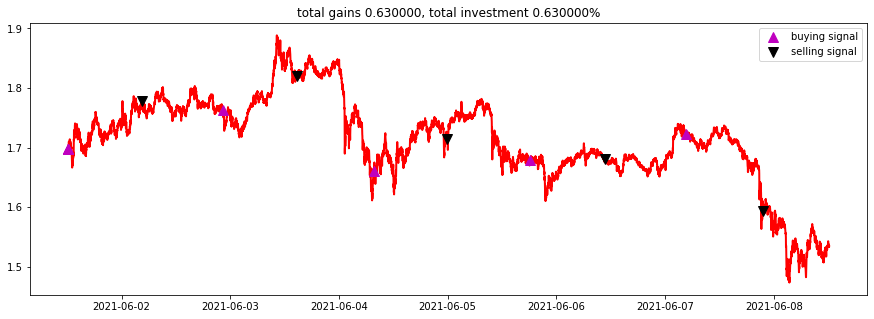

In [ ]:
close = df_full['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.show()

In [ ]:
fees = 0.001
try:
  fees = client.get_trade_fee(symbol=CRYPTO)[0]['makerCommission']
except:
  pass

In [ ]:
portfolio_kwargs = dict(size=np.inf, fees=float(fees), freq=INTERVAL)
portfolio = vbt.Portfolio.from_signals(df_full['close'], states_entry, states_exit, **portfolio_kwargs)

In [ ]:
portfolio.plot().show()

In [ ]:
portfolio.stats()

Start                     2021-06-01 12:14:00+00:00
End                       2021-06-08 12:13:00+00:00
Duration                            7 days 00:00:00
Init. Cash                                      100
Total Profit                               -2.21028
Total Return [%]                           -2.21028
Benchmark Return [%]                       -9.57572
Position Coverage [%]                       39.3849
Max. Drawdown [%]                            11.504
Avg. Drawdown [%]                          0.943023
Max. Drawdown Duration              3 days 15:09:00
Avg. Drawdown Duration    0 days 03:30:39.473684210
Num. Trades                                       4
Win Rate [%]                                     50
Best Trade [%]                              3.04956
Worst Trade [%]                            -7.73382
Avg. Trade [%]                            -0.457852
Max. Trade Duration                 0 days 17:01:00
Avg. Trade Duration                 0 days 16:32:30
Expectancy  

### Online

In [ ]:
info = client.get_symbol_info(CRYPTO)
info

{'symbol': 'ADAUSDT',
 'status': 'TRADING',
 'baseAsset': 'ADA',
 'baseAssetPrecision': 8,
 'quoteAsset': 'USDT',
 'quotePrecision': 8,
 'quoteAssetPrecision': 8,
 'baseCommissionPrecision': 8,
 'quoteCommissionPrecision': 8,
 'orderTypes': ['LIMIT',
  'LIMIT_MAKER',
  'MARKET',
  'STOP_LOSS_LIMIT',
  'TAKE_PROFIT_LIMIT'],
 'icebergAllowed': True,
 'ocoAllowed': True,
 'quoteOrderQtyMarketAllowed': True,
 'isSpotTradingAllowed': True,
 'isMarginTradingAllowed': True,
 'filters': [{'filterType': 'PRICE_FILTER',
   'minPrice': '0.00010000',
   'maxPrice': '1000.00000000',
   'tickSize': '0.00010000'},
  {'filterType': 'PERCENT_PRICE',
   'multiplierUp': '5',
   'multiplierDown': '0.2',
   'avgPriceMins': 5},
  {'filterType': 'LOT_SIZE',
   'minQty': '0.01000000',
   'maxQty': '900000.00000000',
   'stepSize': '0.01000000'},
  {'filterType': 'MIN_NOTIONAL',
   'minNotional': '10.00000000',
   'applyToMarket': True,
   'avgPriceMins': 5},
  {'filterType': 'ICEBERG_PARTS', 'limit': 10},
  {

In [ ]:
while True: 
    binance_data = binance_data.update()
    price = binance_data.get()

    states_buy, states_sell, states_entry, states_exit, total_gains, invest = buy_stock(price.Close, 
                                                                                        initial_state = 1, 
                                                                                        delay = 10, 
                                                                                        initial_money = 1,
                                                                                        max_buy=1,
                                                                                        max_sell=1,
                                                                                        print_log=False)

    states_entry[-1],states_exit[-1]
    
    if not (states_entry[-1] or states_exit[-1]):
        print("doing_noting")
    if states_entry[-1]:
        order = client.create_test_order( ## use test_order for real~
        symbol='ADAUSDT',
        side=Client.SIDE_BUY,
        type=Client.ORDER_TYPE_MARKET,
        quantity=8)
        print("buy",order)
    if states_exit[-1]:
        order = client.create_test_order( ## use test_order for real~
        symbol='ADAUSDT',
        side=Client.SIDE_BUY,
        type=Client.ORDER_TYPE_MARKET,
        quantity=8)
        print("sell",order)
    
    time.sleep(convert_to_seconds(INTERVAL))

buy {}
doing_noting
doing_noting
